In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
import cv2
import csv
import av
import json
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [57]:
info_json_path = os.path.join(os.getcwd() + "/../Video processing" + os.sep + "video_small" + os.sep + "smaller_transition_times.json")
with open(info_json_path, 'r', encoding='utf-8') as file:
    info_json = json.load(file)

In [58]:
path_to_data = os.path.normpath(os.getcwd() + "/../Image processing" + os.sep + "video_proc/")

In [59]:
train_path = os.path.join(path_to_data, 'train')
val_path = os.path.join(path_to_data, 'val')

In [60]:
# List all files in the directory
image_path = train_path
files = os.listdir(image_path)

# Filter out only image files
image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

# If there are image files
if image_files:
    # Get the first image file
    first_image = image_files[0]
    
    # Open the image using Pillow
    with Image.open(os.path.join(image_path, first_image)) as img:
        # Get the size of the image
        width, height = img.size
        # Get the mode of the image
        mode = img.mode
        
        # Get the number of channels based on the mode
        channels = len(mode)
        print(f"The size of the first image '{first_image}' is {width}x{height} pixels.")
        print(f"The image mode is '{mode}' with {channels} channel(s).")
else:
    print("No image files found in the directory.")

The size of the first image '25 Best Trampoline Fail Nominees - FailArmy Hall of Fame (July 2017)18_00.jpg' is 240x240 pixels.
The image mode is 'L' with 1 channel(s).


In [27]:
filename = '25 best'
for i in range(3):
    s = str(i).zfill(2)
    print(filename + '_' + s + '.jpg')

25 best_00.jpg
25 best_01.jpg
25 best_02.jpg


In [64]:
from torchvision.io import read_image

class VideoImageDataset(Dataset):
    def __init__(self, img_dir, device, transform=None, mode='train'):
        self.img_dir = img_dir
        self.transform = transform
        self.mode = mode
        self.device = device
        self.data = self.load_data()
        

    def __len__(self):
        return len(self.data)
    
    def load_data(self):
        data = []
        for filename in info_json:
            if info_json[filename]['category'] != self.mode:
                continue

            csv_path = os.path.join(self.img_dir, filename + '_labels.csv')
            for i in range(25):
                num = str(i).zfill(2)
                img_path = os.path.join(self.img_dir, filename + '_' + num + '.jpg')
                data.append((img_path, csv_path, i))
        
        return data
            
    def __getitem__(self, idx):
        img_path, csv_path, id = self.data[idx]
        image = Image.open(img_path)

        with open(csv_path, 'r', encoding='utf-8') as file:
            csv_reader = csv.reader(file)
            
            row = next(csv_reader)
            label = 0
            # Access the i'th element from the row and parse it as an integer
            try:
                label = int(row[id])
            except IndexError:
                print(f"The index {id} is out of range.")
            except ValueError:
                print(f"The value at index {id} is not an integer.")
            
        if self.transform:
            image = self.transform(image)
        return image, label

In [65]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [66]:
train_dataset = VideoImageDataset(train_path, device=device, transform=transform, mode='train')
val_dataset = VideoImageDataset(val_path, device=device, transform=transform, mode='val')

In [42]:
for i in range(val_dataset.__len__()):
    img, label = train_dataset.__getitem__(i)
    img = img.permute(1, 2, 0).numpy()
    if label == None:
        print('exist None labels')
    # plt.imshow(img, cmap='gray')
    # plt.title(f'Label: {label}')
    # plt.axis('off')
    # plt.show()

In [67]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [44]:
for batch_idx, (images, labels) in enumerate(train_dataloader):
    # Access image-label tuple at a specific index
    index = 10  # Example index
    if batch_idx * train_dataloader.batch_size <= index < (batch_idx + 1) * train_dataloader.batch_size:
        image, label = images[index % train_dataloader.batch_size], labels[index % train_dataloader.batch_size]
        # Use image and label as needed
        print("Image shape:", image.shape)
        print("Label:", label)
        break  # Break the loop after accessing the desired tuplef

Image shape: torch.Size([1, 224, 224])
Label: tensor(0)


In [68]:
for images, labels in train_dataloader:
    # Move data to GPU
    images = images.to(device)
    labels = labels.to(device)

for images, labels in val_dataloader:
    # Move data to GPU
    images = images.to(device)
    labels = labels.to(device)

In [69]:
import torch
import pickle

# Save train and val datasets
with open('train_dataset.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)

with open('val_dataset.pkl', 'wb') as f:
    pickle.dump(val_dataset, f)

# Save train and val dataloaders
with open('train_dataloader.pkl', 'wb') as f:
    pickle.dump(train_dataloader, f)

with open('val_dataloader.pkl', 'wb') as f:
    pickle.dump(val_dataloader, f)



In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NaiveCNN(nn.Module):
    def __init__(self):
        super(NaiveCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize the model
model = NaiveCNN().to(device)

# Print the model architecture
print(model)


NaiveCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [87]:
train_target = []
val_target = []
for i in range(train_dataset.__len__()):
    img, label = train_dataset.__getitem__(i)
    train_target.append(label)

for i in range(val_dataset.__len__()):
    img, label = val_dataset.__getitem__(i)
    val_target.append(label)

In [ ]:
print(train_target)
print(val_target)

In [90]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.array([0, 1])), y=train_target)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(class_weights)

tensor([0.7023, 1.7359], device='cuda:0')


In [79]:
from tqdm import tqdm
from sklearn.metrics import f1_score
import torch.optim as optim

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your model, loss function, and optimizer
model = NaiveCNN().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(model.parameters(), lr=0.02, weight_decay=0.001)

# Lists to store training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
f1_scores = []

In [80]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training dataset
    for images, labels in tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}/{num_epochs}', unit='batch'):
        # Move images and labels to the GPU
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update running loss
        running_loss += loss.item()

    # Compute training accuracy and loss for the epoch
    train_epoch_loss = running_loss / len(train_dataloader)
    train_epoch_accuracy = 100 * correct / total

    # Store training loss and accuracy
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for val_images, val_labels in tqdm(val_dataloader, desc=f'Validation Epoch {epoch+1}/{num_epochs}', unit='batch'):
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()
            val_running_loss += val_loss.item()

            val_preds.extend(val_predicted.cpu().numpy())
            val_targets.extend(val_labels.cpu().numpy())

    # Compute validation loss, accuracy, and F1 score for the epoch
    val_epoch_loss = val_running_loss / len(val_dataloader)
    val_epoch_accuracy = 100 * val_correct / val_total
    val_f1 = f1_score(val_targets, val_preds, average='macro')
    
    # Store validation loss, accuracy, and F1 score
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)
    f1_scores.append(val_f1)

    print(f'Training Epoch [{epoch+1}/{num_epochs}], Loss: {train_epoch_loss:.4f}, Accuracy: {train_epoch_accuracy:.2f}%')
    print(f'Validation Epoch [{epoch+1}/{num_epochs}], Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.2f}%, F1 Score: {val_f1:.4f}')

# Save the trained model to a file
torch.save(model.state_dict(), "NaiveCNN.pth")



Validation Epoch 1/20: 100%|██████████| 94/94 [00:09<00:00, 10.14batch/s]


Training Epoch [1/20], Loss: 0.6931, Accuracy: 59.29%
Validation Epoch [1/20], Loss: 0.6921, Accuracy: 43.65%, F1 Score: 0.4361


Validation Epoch 2/20: 100%|██████████| 94/94 [00:09<00:00, 10.14batch/s]


Training Epoch [2/20], Loss: 0.6923, Accuracy: 55.73%
Validation Epoch [2/20], Loss: 0.6906, Accuracy: 47.45%, F1 Score: 0.4738


Validation Epoch 3/20: 100%|██████████| 94/94 [00:09<00:00, 10.20batch/s]


Training Epoch [3/20], Loss: 0.6914, Accuracy: 54.64%
Validation Epoch [3/20], Loss: 0.6906, Accuracy: 63.98%, F1 Score: 0.5313


Validation Epoch 4/20: 100%|██████████| 94/94 [00:09<00:00, 10.19batch/s]


Training Epoch [4/20], Loss: 0.6900, Accuracy: 56.57%
Validation Epoch [4/20], Loss: 0.6879, Accuracy: 47.50%, F1 Score: 0.4741


Validation Epoch 5/20: 100%|██████████| 94/94 [00:09<00:00, 10.29batch/s]


Training Epoch [5/20], Loss: 0.6892, Accuracy: 55.40%
Validation Epoch [5/20], Loss: 0.6873, Accuracy: 54.43%, F1 Score: 0.5279


Validation Epoch 6/20: 100%|██████████| 94/94 [00:09<00:00, 10.19batch/s]


Training Epoch [6/20], Loss: 0.6872, Accuracy: 55.97%
Validation Epoch [6/20], Loss: 0.6890, Accuracy: 59.18%, F1 Score: 0.5376


Validation Epoch 7/20: 100%|██████████| 94/94 [00:09<00:00, 10.18batch/s]


Training Epoch [7/20], Loss: 0.6859, Accuracy: 57.37%
Validation Epoch [7/20], Loss: 0.6891, Accuracy: 56.28%, F1 Score: 0.5271


Validation Epoch 8/20: 100%|██████████| 94/94 [00:09<00:00, 10.27batch/s]


Training Epoch [8/20], Loss: 0.6834, Accuracy: 57.39%
Validation Epoch [8/20], Loss: 0.6953, Accuracy: 63.62%, F1 Score: 0.5266


Validation Epoch 9/20: 100%|██████████| 94/94 [00:09<00:00, 10.34batch/s]


Training Epoch [9/20], Loss: 0.6810, Accuracy: 57.19%
Validation Epoch [9/20], Loss: 0.6938, Accuracy: 58.55%, F1 Score: 0.5201


Validation Epoch 10/20: 100%|██████████| 94/94 [00:09<00:00, 10.10batch/s]


Training Epoch [10/20], Loss: 0.6780, Accuracy: 57.81%
Validation Epoch [10/20], Loss: 0.6901, Accuracy: 52.27%, F1 Score: 0.5014


Validation Epoch 11/20: 100%|██████████| 94/94 [00:09<00:00, 10.22batch/s]


Training Epoch [11/20], Loss: 0.6729, Accuracy: 58.21%
Validation Epoch [11/20], Loss: 0.6905, Accuracy: 49.90%, F1 Score: 0.4855


Validation Epoch 12/20: 100%|██████████| 94/94 [00:09<00:00, 10.20batch/s]


Training Epoch [12/20], Loss: 0.6668, Accuracy: 58.79%
Validation Epoch [12/20], Loss: 0.6922, Accuracy: 55.78%, F1 Score: 0.5188


Validation Epoch 13/20: 100%|██████████| 94/94 [00:09<00:00, 10.15batch/s]


Training Epoch [13/20], Loss: 0.6576, Accuracy: 60.12%
Validation Epoch [13/20], Loss: 0.6938, Accuracy: 57.88%, F1 Score: 0.5280


Validation Epoch 14/20: 100%|██████████| 94/94 [00:09<00:00, 10.32batch/s]


Training Epoch [14/20], Loss: 0.6468, Accuracy: 61.18%
Validation Epoch [14/20], Loss: 0.6936, Accuracy: 51.60%, F1 Score: 0.5014


Validation Epoch 15/20: 100%|██████████| 94/94 [00:12<00:00,  7.40batch/s]


Training Epoch [15/20], Loss: 0.6302, Accuracy: 63.51%
Validation Epoch [15/20], Loss: 0.7020, Accuracy: 52.35%, F1 Score: 0.5034


Validation Epoch 16/20: 100%|██████████| 94/94 [00:10<00:00,  8.99batch/s]


Training Epoch [16/20], Loss: 0.6059, Accuracy: 65.97%
Validation Epoch [16/20], Loss: 0.7213, Accuracy: 50.92%, F1 Score: 0.4953


Validation Epoch 17/20: 100%|██████████| 94/94 [00:09<00:00, 10.27batch/s]


Training Epoch [17/20], Loss: 0.5782, Accuracy: 69.03%
Validation Epoch [17/20], Loss: 0.7513, Accuracy: 63.18%, F1 Score: 0.5553


Validation Epoch 18/20: 100%|██████████| 94/94 [00:09<00:00, 10.16batch/s]


Training Epoch [18/20], Loss: 0.5443, Accuracy: 72.23%
Validation Epoch [18/20], Loss: 0.7777, Accuracy: 54.27%, F1 Score: 0.5212


Validation Epoch 19/20: 100%|██████████| 94/94 [00:09<00:00, 10.25batch/s]


Training Epoch [19/20], Loss: 0.5022, Accuracy: 75.36%
Validation Epoch [19/20], Loss: 0.7911, Accuracy: 55.97%, F1 Score: 0.5261


Validation Epoch 20/20: 100%|██████████| 94/94 [00:09<00:00, 10.21batch/s]


Training Epoch [20/20], Loss: 0.4564, Accuracy: 78.00%
Validation Epoch [20/20], Loss: 0.8149, Accuracy: 57.40%, F1 Score: 0.5466


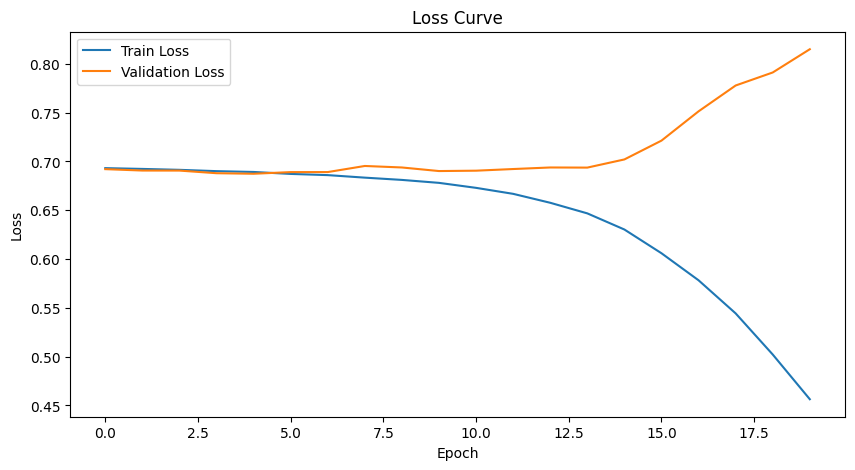

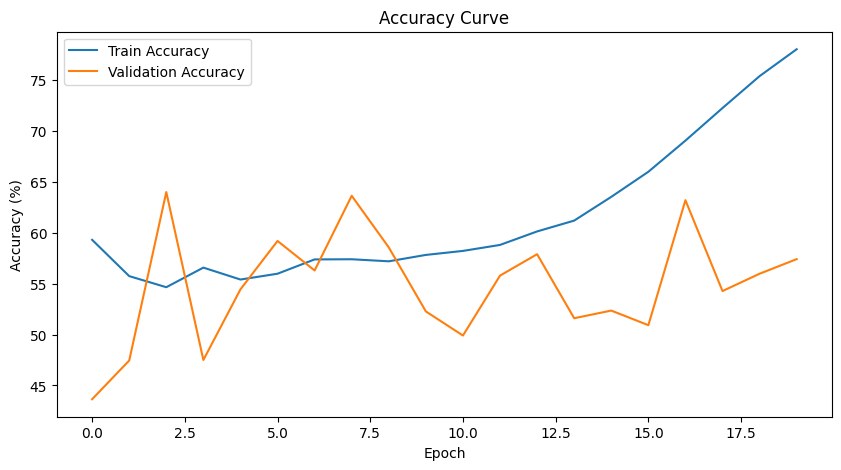

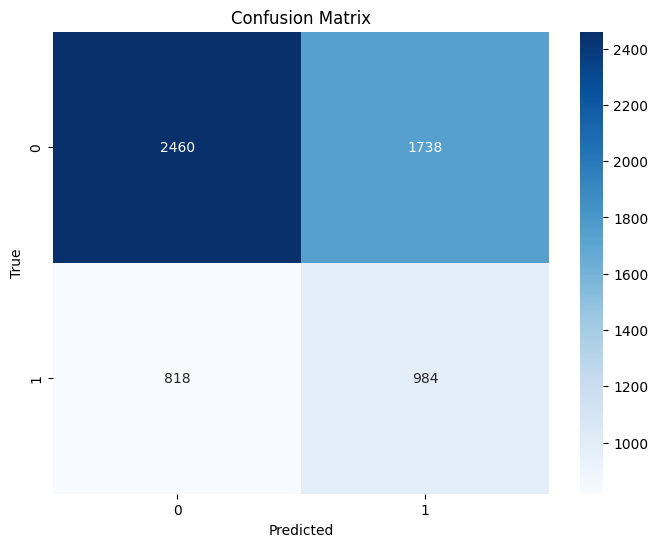

In [81]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# Plot Confusion Matrix
model.eval()  # Ensure model is in evaluation mode
val_preds = []
val_targets = []

with torch.no_grad():
    for val_images, val_labels in val_dataloader:
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        val_outputs = model(val_images)
        _, val_predicted = torch.max(val_outputs, 1)
        val_preds.extend(val_predicted.cpu().numpy())
        val_targets.extend(val_labels.cpu().numpy())

cm = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Potential code, using pre-trained RN34 / RN50
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
class BinaryClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super(BinaryClassifier, self).__init__()
        
        # Load the pre-trained ResNet34 model and freeze its parameters
        self.resnet = models.resnet34(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Replace the last fully connected layer with an identity layer
        self.resnet.fc = nn.Identity()

        # Define the fully connected layers
        self.fc1 = nn.Linear(num_ftrs, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Pass the input through the pre-trained ResNet34
        x = self.resnet(x)
        
        # Flatten the output of ResNet
        x = x.view(x.size(0), -1)
        
        # Pass the flattened output through the fully connected layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        
        return x

# Initialize the model
model = BinaryClassifier().to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)